If on google collab, if not skip the following cell

In [128]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd '/content/gdrive/MyDrive/TFG_Matematicas'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/TFG_Matematicas


## Preparation to test models

In [129]:
import numpy as np
import pandas as pd
import keras
import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, SimpleRNN, LSTM, Input, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils import plot_model
from utils.utils import *


In [130]:
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
print("All devices: ", tf.config.list_logical_devices('TPU'))
tpu_strategy = tf.distribute.TPUStrategy(tpu)

BaseException: ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

In [141]:
train_idxs = read_indexes('./utils/train.txt')
validation_idxs =  read_indexes('./utils/validation.txt')
test_idxs = read_indexes('./utils/test.txt')

In [142]:
data_indexes = [(i+1,j+1) for i in range(10) for j in range(2000)]
parameters = load_parameter_list()
df_parameters = pd.DataFrame(parameters, columns=['cx', 'cy', 'a', 'b', 'theta', 'e1', 'e2'])
df_parameters['data_index'] = data_indexes

y_train = df_parameters[df_parameters['data_index'].isin(train_idxs)].drop('data_index', axis = 1)
y_validation = df_parameters[df_parameters['data_index'].isin(validation_idxs)].drop('data_index', axis = 1)
y_test = df_parameters[df_parameters['data_index'].isin(test_idxs)].drop('data_index', axis = 1)

In [143]:
X_train = np.array(load_data_multithreaded(train_idxs,50, small = True))
print('train loaded')
X_validation = np.array(load_data_multithreaded(validation_idxs,50, small = True))
print('validation loaded')
X_test = np.array(load_data_multithreaded(test_idxs,50, small = True))
print('test loaded')

KeyboardInterrupt: 

In [ ]:
mean = np.mean(X_train.flatten())
std = np.std(X_train.flatten())

In [ ]:
mean, std

In [ ]:
# X_train_norm = (X_train-mean)/std
# X_validation_norm = (X_validation-mean)/std
# X_test_norm = (X_test-mean)/std

# Preparing metrics

In [ ]:
def e1_mse(y_true, y_pred):
    output = y_pred[:, -2]
    output_mae = tf.keras.metrics.mean_squared_error(y_true[:, -2], output)
    return output_mae
def e2_mse(y_true, y_pred):
    output = y_pred[:, -1]
    output_mae = tf.keras.metrics.mean_squared_error(y_true[:, -1], output)
    return output_mae


def e1_mae(y_true, y_pred):
    output = y_pred[:, -2]
    output_mae = tf.keras.metrics.mean_absolute_error(y_true[:, -2], output)
    return output_mae
def e2_mae(y_true, y_pred):
    output = y_pred[:, -1]
    output_mae = tf.keras.metrics.mean_absolute_error(y_true[:, -1], output)
    return output_mae

def e1_rmse(y_true, y_pred):
    output = y_pred[:, -2]
    output_rmse = rmse(y_true[:, -2], output)
    return output_rmse
def e2_rmse(y_true, y_pred):
    output = y_pred[:, -1]
    output_rmse = rmse(y_true[:, -1], output)
    return output_rmse

def e1_r2score(y_true, y_pred):
    output = y_pred[:, -2]
    output_rmse = r_squared(y_true[:, -2], output)
    return output_rmse
def e2_r2score(y_true, y_pred):
    output = y_pred[:, -1]
    output_rmse = r_squared(y_true[:, -1], output)
    return output_rmse

In [ ]:
METRICS=[tf.keras.metrics.RootMeanSquaredError(name='rmse'),
         tf.keras.metrics.MeanAbsoluteError(name='mae'),
         tf.keras.metrics.R2Score(name='r2score'),
         e1_mse,e2_mse,e1_mae,e2_mae,e1_rmse,e2_rmse, e1_r2score, e2_r2score]


# Feedforward model

In [133]:
pip install visualkeras

In [134]:
import visualkeras

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_15 (Flatten)        (None, 7480)              0         
                                                                 
 dense_90 (Dense)            (None, 1024)              7660544   
                                                                 
 dense_91 (Dense)            (None, 512)               524800    
                                                                 
 dense_92 (Dense)            (None, 256)               131328    
                                                                 
 dense_93 (Dense)            (None, 128)               32896     
                                                                 
 dense_94 (Dense)            (None, 64)                8256      
                                                                 
 dense_95 (Dense)            (None, 7)               

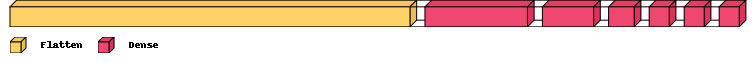

In [135]:
#with tpu_strategy.scope(): , WandbMetricsLogger(log_freq=5)
  # Feedforward model
#with tf.device('/device:GPU:0'):
feedforward = tf.keras.Sequential([
    Input(shape=(440, 17)),
    Flatten(),
    Dense(1024, activation='relu'),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(7)
])

feedforward.compile(optimizer='adam', loss='mse', metrics=[METRICS])
feedforward.summary()
plot_model(feedforward, to_file='figures/feedforward_1.png', show_shapes=True, show_layer_names=False)
visualkeras.layered_view(feedforward, legend=True, to_file='figures/feedforward_2.png', spacing = 15)

In [136]:
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
history = feedforward.fit(X_train, y_train, validation_data=(X_validation, y_validation), epochs=2, verbose = 1, callbacks=[early_stopping])


Epoch 1/2
265/265 [==============================] - 32s 115ms/step - loss: 1.3401 - rmse: 1.1576 - mae: 0.7716 - r2score: -0.0343 - e1_mse: 1.8790 - e2_mse: 5.0240 - e1_mae: 1.0435 - e2_mae: 1.8723 - e1_rmse: 1.3281 - e2_rmse: 2.2053 - e1_r2score: -0.5520 - e2_r2score: -0.0415 - val_loss: 1.0483 - val_rmse: 1.0239 - val_mae: 0.6696 - val_r2score: 0.2239 - val_e1_mse: 1.3923 - val_e2_mse: 4.1049 - val_e1_mae: 0.8183 - val_e2_mae: 1.7135 - val_e1_rmse: 1.1492 - val_e2_rmse: 2.0130 - val_e1_r2score: -0.9372 - val_e2_r2score: -0.1513
Epoch 2/2
265/265 [==============================] - 31s 116ms/step - loss: 0.9886 - rmse: 0.9943 - mae: 0.6366 - r2score: 0.3184 - e1_mse: 1.2943 - e2_mse: 4.1435 - e1_mae: 0.8419 - e2_mae: 1.6956 - e1_rmse: 1.1148 - e2_rmse: 2.0198 - e1_r2score: -1.0897 - e2_r2score: -0.2122 - val_loss: 0.8728 - val_rmse: 0.9342 - val_mae: 0.6035 - val_r2score: 0.3560 - val_e1_mse: 1.1027 - val_e2_mse: 3.5772 - val_e1_mae: 0.7284 - val_e2_mae: 1.5893 - val_e1_rmse: 1.0212 -

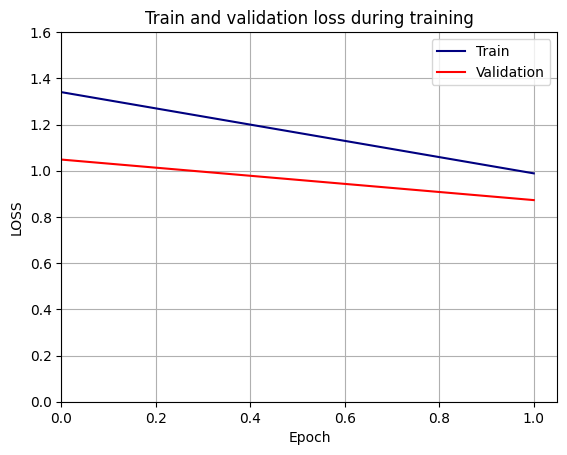

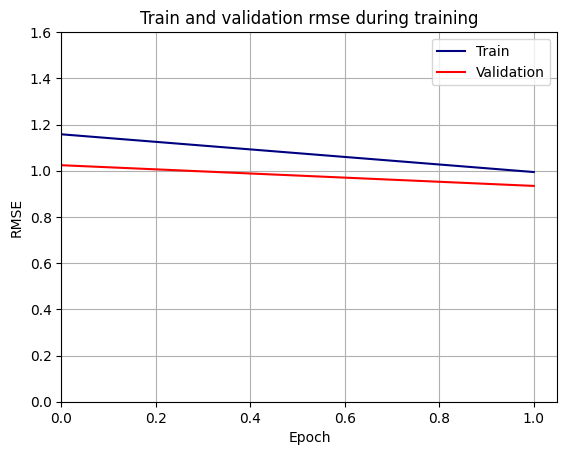

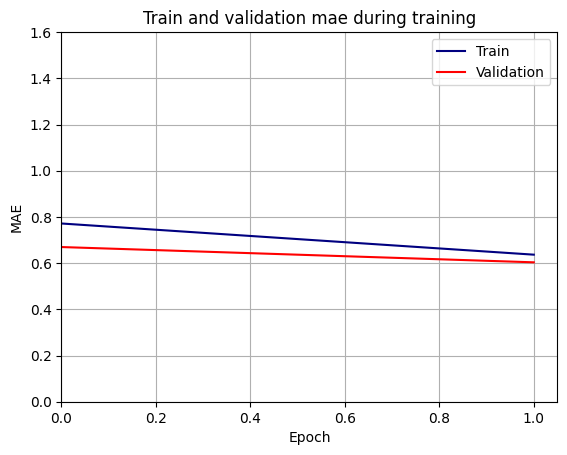

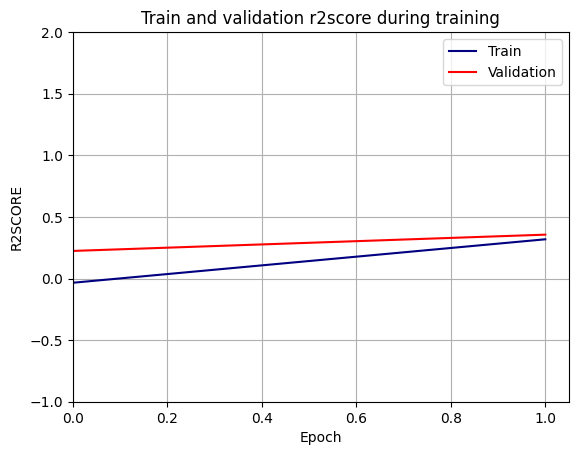

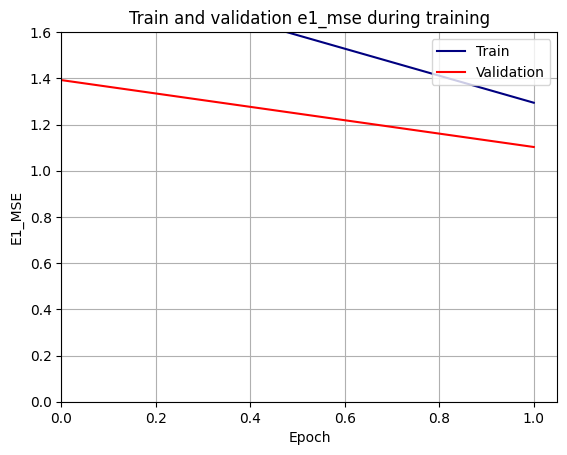

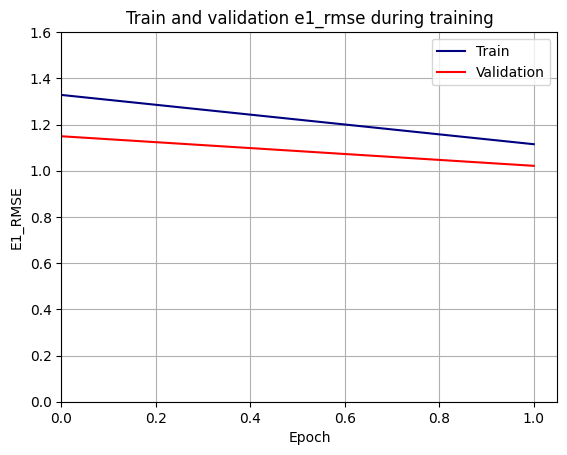

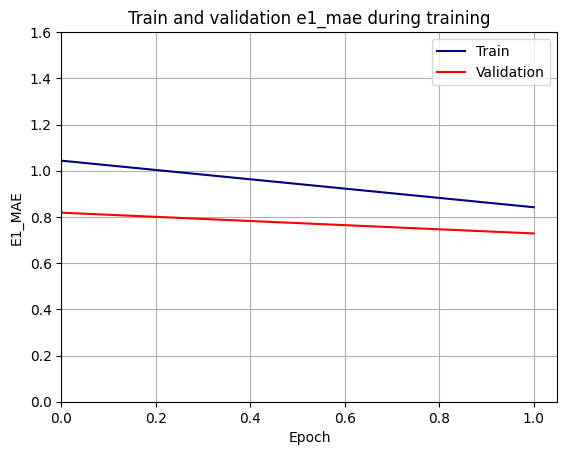

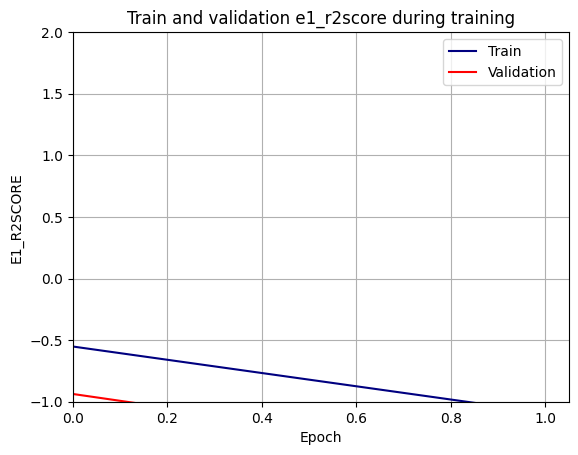

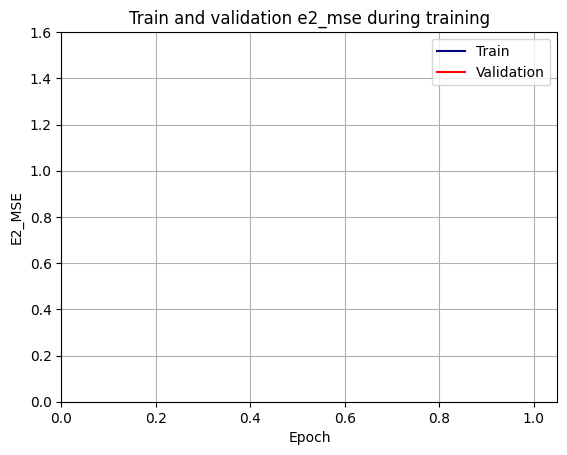

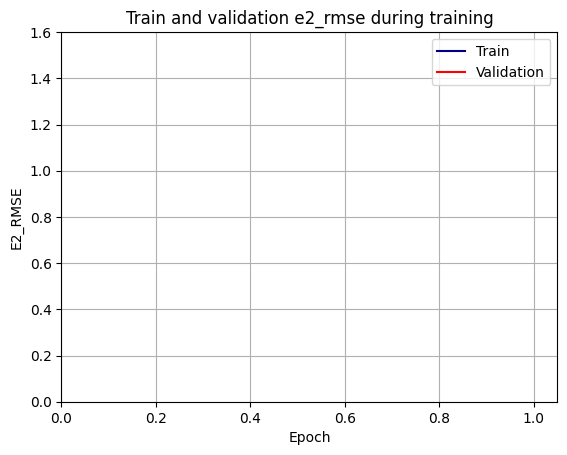

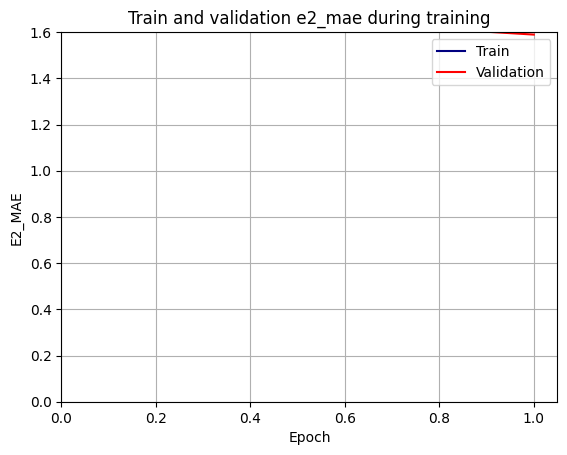

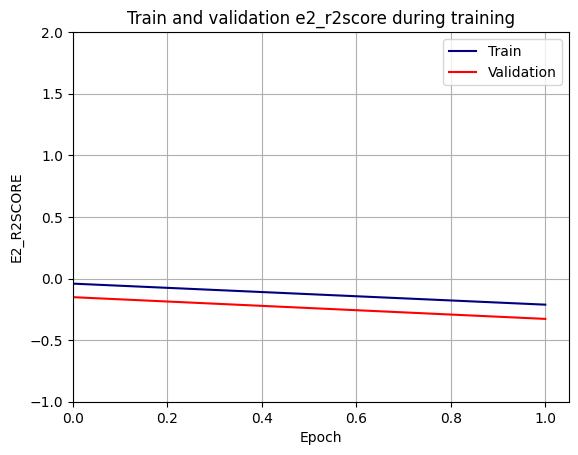

In [138]:
model = 'feedforward'
plot_metrics(history, 'loss', file = './figures/mse_small_{model}')
plot_metrics(history, 'rmse', file = './figures/rmse_small_{model}')
plot_metrics(history, 'mae', file = './figures/mae_small_{model}')
plot_metrics(history, 'r2score', file = './figures/r2score_small_{model}', lim_y_bottom = -1, lim_y_top = 2)
plot_metrics(history, 'e1_mse', file = './figures/e1_mse_small_{model}')
plot_metrics(history, 'e1_rmse', file = './figures/e1_rmse_small_{model}')
plot_metrics(history, 'e1_mae', file = './figures/e1_mae_small_{model}')
plot_metrics(history, 'e1_r2score', file = './figures/e1_r2score_small_{model}', lim_y_bottom = -1, lim_y_top = 2)
plot_metrics(history, 'e2_mse', file = './figures/e2_mse_small_{model}')
plot_metrics(history, 'e2_rmse', file = './figures/e2_rmse_small_{model}')
plot_metrics(history, 'e2_mae', file = './figures/e2_mae_small_{model}')
plot_metrics(history, 'e2_r2score', file = './figures/e2_r2score_small_{model}', lim_y_bottom = -1, lim_y_top = 2)

In [151]:
model_evaluation(feedforward, X_test, y_test, random_samples = 10)

89/89 [==============================] - 2s 20ms/step - loss: 0.9072 - rmse: 0.9525 - mae: 0.6126 - r2score: 0.3478 - e1_mse: 1.0531 - e2_mse: 3.7788 - e1_mae: 0.7063 - e2_mae: 1.6514 - e1_rmse: 1.0021 - e2_rmse: 1.9345 - e1_r2score: -1.6773 - e2_r2score: -0.3274
Test mse: 0.9072030186653137
Test rmse: 0.9524719715118408
Test mae: 0.6126143336296082
Test R2: 0.3478240966796875
89/89 [==============================] - 2s 19ms/step
Metrics for parameters e1 and e2:
Parameter e1:
  	MSE: 1.060, RMSE: 1.030, MAE: 1.060, R2: -1.435
Parameter e2:
  	MSE: 3.771, RMSE: 1.942, MAE: 7.414, R2: -0.358
1/1 [==============================] - 0s 31ms/step

Random prediction examples
Parameters:	cx	cy	a	b	theta	e1	e2
------------
real:		 0.832	5.055	1.320	0.533	0.248	0.085	3.808
prediction:	 0.133	3.259	1.157	0.229	0.185	1.484	4.975
------------
real:		 1.659	2.758	1.022	0.322	-0.512	1.495	5.347
prediction:	 1.105	2.582	1.196	0.320	0.016	1.678	4.990
------------
real:		 0.467	1.646	1.835	0.616	0.219	

# Convolutional model

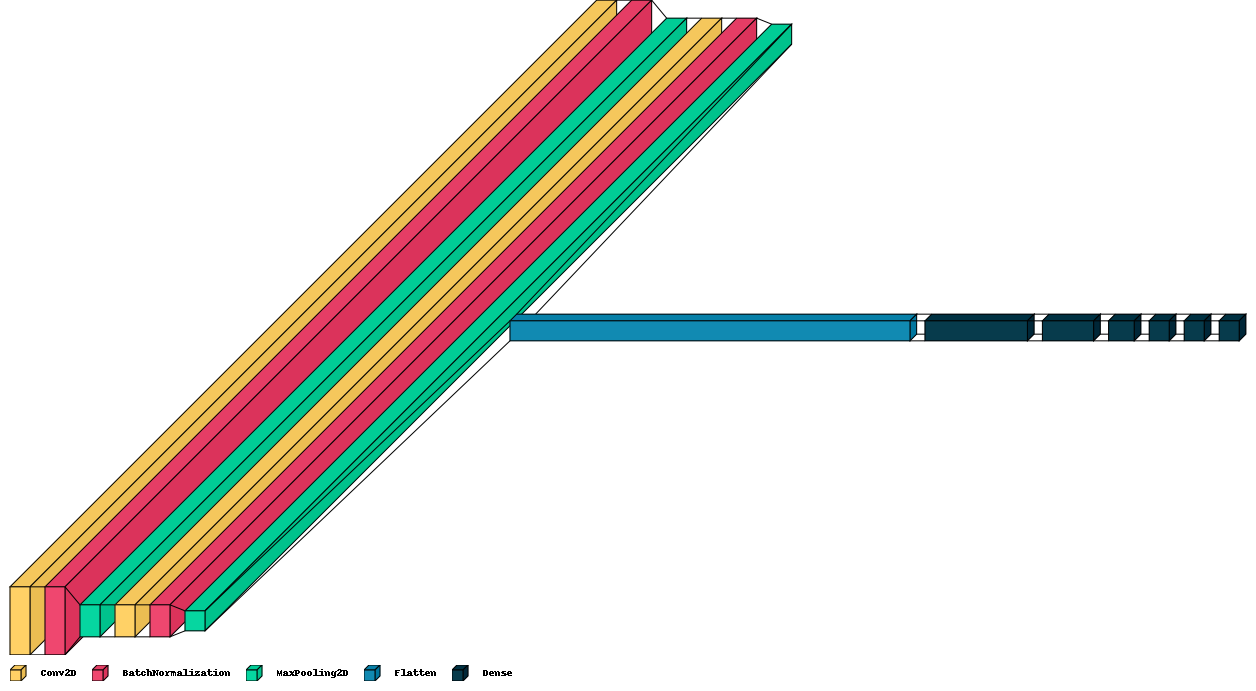

In [ ]:
#with tf.device('/device:GPU:0'):
cnn = tf.keras.Sequential([
  Conv2D(32, (3, 3), activation='relu', input_shape=(440, 17, 1), padding='same'),
  BatchNormalization(),
  MaxPooling2D((1, 2)),

  Conv2D(64, (3, 3), activation='relu', padding='same'),
  BatchNormalization(),#
  MaxPooling2D((1, 2)),

  Flatten(),

  Dense(1024, activation='relu'),
  Dense(512, activation='relu'),
  Dense(256, activation='relu'),
  Dense(128, activation='relu'),
  Dense(64, activation='relu'),
  Dense(7)
])

cnn.compile(optimizer='adam', loss='mse', metrics=[METRICS])
#cnn.summary()
plot_model(cnn, to_file='figures/cnn_1.png', show_shapes=True, show_layer_names=False)
visualkeras.layered_view(cnn, legend=True, to_file='figures/cnn_2.png', spacing = 15)

In [ ]:
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)
history = cnn.fit(X_train, y_train, validation_data=(X_validation, y_validation), epochs=100, verbose = 1, callbacks=[early_stopping])

Epoch 1/50
133/133 [==============================] - 10s 51ms/step - loss: 15.4103 - rmse: 3.3577 - mae: 1.1139 - r2score: -18.7992 - val_loss: 6.9060 - val_rmse: 2.6279 - val_mae: 1.8953 - val_r2score: -3.7471
Epoch 2/50
133/133 [==============================] - 7s 51ms/step - loss: 1.0430 - rmse: 1.0213 - mae: 0.6750 - r2score: 0.0778 - val_loss: 6.7272 - val_rmse: 2.5937 - val_mae: 1.8591 - val_r2score: -3.5652
Epoch 3/50
133/133 [==============================] - 7s 55ms/step - loss: 0.8948 - rmse: 0.9459 - mae: 0.6120 - r2score: 0.2804 - val_loss: 6.2386 - val_rmse: 2.4977 - val_mae: 1.7803 - val_r2score: -3.1911
Epoch 4/50
133/133 [==============================] - 7s 49ms/step - loss: 0.8198 - rmse: 0.9055 - mae: 0.5777 - r2score: 0.3395 - val_loss: 4.9893 - val_rmse: 2.2337 - val_mae: 1.5621 - val_r2score: -2.1909
Epoch 5/50
133/133 [==============================] - 7s 54ms/step - loss: 0.8233 - rmse: 0.9074 - mae: 0.5694 - r2score: 0.3541 - val_loss: 2.5262 - val_rmse: 1.58

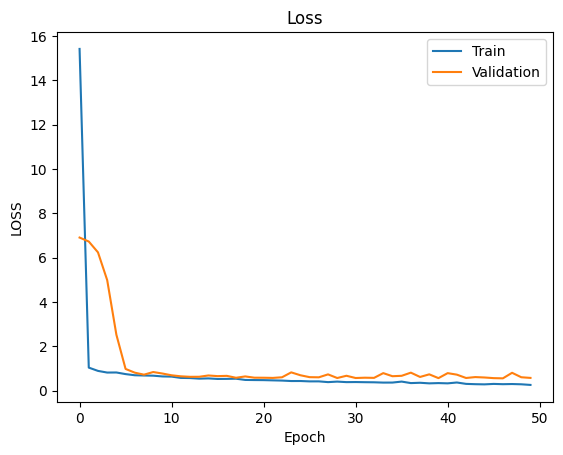

In [ ]:
model = 'cnn'
plot_metrics(history, 'loss', file = './figures/mse_small_{model}')
plot_metrics(history, 'rmse', file = './figures/rmse_small_{model}')
plot_metrics(history, 'mae', file = './figures/mae_small_{model}')
plot_metrics(history, 'r2score', file = './figures/r2score_small_{model}', lim_y_bottom = -1, lim_y_top = 2)
plot_metrics(history, 'e1_mse', file = './figures/e1_mse_small_{model}')
plot_metrics(history, 'e1_rmse', file = './figures/e1_rmse_small_{model}')
plot_metrics(history, 'e1_mae', file = './figures/e1_mae_small_{model}')
plot_metrics(history, 'e1_r2score', file = './figures/e1_r2score_small_{model}', lim_y_bottom = -1, lim_y_top = 2)
plot_metrics(history, 'e2_mse', file = './figures/e2_mse_small_{model}')
plot_metrics(history, 'e2_rmse', file = './figures/e2_rmse_small_{model}')
plot_metrics(history, 'e2_mae', file = './figures/e2_mae_small_{model}')
plot_metrics(history, 'e2_r2score', file = './figures/e2_r2score_small_{model}', lim_y_bottom = -1, lim_y_top = 2)

In [ ]:
model_evaluation(cnn, X_test, y_test, random_samples = 10)

45/45 [==============================] - 0s 8ms/step - loss: 0.5721 - rmse: 0.7564 - mae: 0.4493 - r2score: 0.5813
Test mse: 0.5720738172531128
Test rmse: 0.7563555240631104
Test mae: 0.4493117034435272
Test r2score: 0.5813074707984924
1/1 [==============================] - 0s 185ms/step


Random prediction examples
Parameters:	cx	cy	a	b	theta	e1	e2
------------
real:		 1.502	4.082	0.885	0.820	0.264	5.747	3.146
prediction:	 2.033	4.881	1.099	0.951	0.117	6.662	4.519
------------
real:		 -0.393	2.920	0.918	0.566	0.174	3.743	4.977
prediction:	 -0.312	3.444	0.879	0.770	0.347	3.875	4.816
------------
real:		 2.470	3.301	0.989	0.507	0.282	1.668	7.529
prediction:	 2.775	3.524	1.053	0.847	0.002	1.503	6.327
------------
real:		 1.253	3.567	0.953	0.459	0.406	2.176	6.112
prediction:	 1.475	4.116	0.975	0.727	0.180	1.969	4.974
------------
real:		 -1.209	3.257	1.073	0.474	-0.239	2.186	5.518
prediction:	 -1.049	3.929	1.036	0.711	-0.113	1.817	5.428
------------
real:		 -0.318	2.314	0.592	0.324	0.403	

# Recurrent Neural Network with simple RNN layer

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 440, 30)           1440      
                                                                 
 flatten_12 (Flatten)        (None, 13200)             0         
                                                                 
 dense_68 (Dense)            (None, 1024)              13517824  
                                                                 
 dense_69 (Dense)            (None, 256)               262400    
                                                                 
 dense_70 (Dense)            (None, 64)                16448     
                                                                 
 dense_71 (Dense)            (None, 7)                 455       
                                                                 
Total params: 13798567 (52.64 MB)
Trainable params: 1

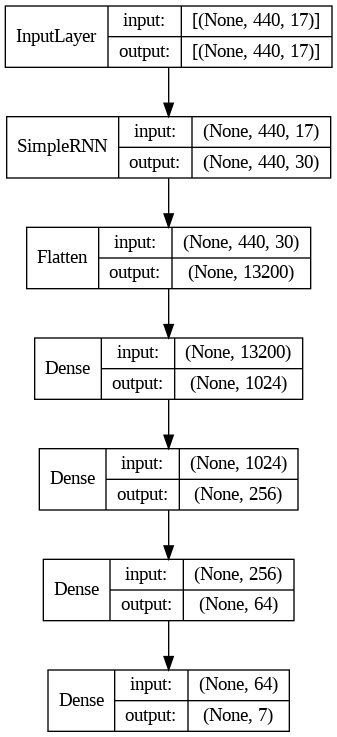

In [ ]:
#with tf.device('/device:GPU:0'):
rnn = tf.keras.Sequential([
    SimpleRNN(30, input_shape=(440, 17), return_sequences=True),
    Flatten(),
    Dense(1024, activation='relu'),
    Dense(256, activation='relu'),
    Dense(64, activation='relu'),
    Dense(7)
])

rnn.compile(optimizer='adam', loss='mse', metrics=METRICS)
rnn.summary()
plot_model(rnn, to_file='figures/rnn_1.png', show_shapes=True, show_layer_names=False)
#visualkeras.layered_view(rnn, legend=True, to_file='figures/rnn_2.png', spacing = 15)

In [ ]:
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)
history = rnn.fit(X_train, y_train, validation_data=(X_validation, y_validation), epochs=100, verbose = 1, callbacks=[early_stopping])

Epoch 1/20
133/133 [==============================] - 44s 316ms/step - loss: 1.3861 - rmse: 1.1864 - mae: 0.7922 - r2score: -0.1893 - val_loss: 1.2267 - val_rmse: 1.1076 - val_mae: 0.7050 - val_r2score: 0.2042
Epoch 2/20
133/133 [==============================] - 42s 316ms/step - loss: 1.0820 - rmse: 1.0402 - mae: 0.6755 - r2score: 0.2489 - val_loss: 1.1198 - val_rmse: 1.0582 - val_mae: 0.6627 - val_r2score: 0.2765
Epoch 3/20
133/133 [==============================] - 44s 328ms/step - loss: 0.9820 - rmse: 0.9910 - mae: 0.6287 - r2score: 0.3370 - val_loss: 1.0390 - val_rmse: 1.0193 - val_mae: 0.6283 - val_r2score: 0.3409
Epoch 4/20
133/133 [==============================] - 42s 319ms/step - loss: 0.9391 - rmse: 0.9691 - mae: 0.6144 - r2score: 0.3609 - val_loss: 0.9560 - val_rmse: 0.9778 - val_mae: 0.5958 - val_r2score: 0.3798
Epoch 5/20
133/133 [==============================] - 42s 320ms/step - loss: 0.9028 - rmse: 0.9502 - mae: 0.5966 - r2score: 0.3800 - val_loss: 0.9061 - val_rmse: 0

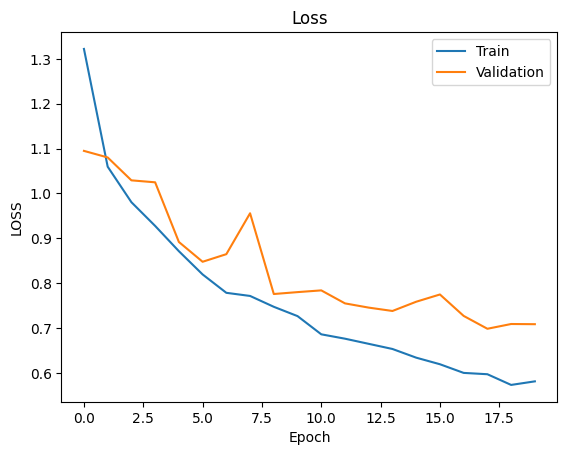

In [ ]:
model = 'rnn'
plot_metrics(history, 'loss', file = './figures/mse_small_{model}')
plot_metrics(history, 'rmse', file = './figures/rmse_small_{model}')
plot_metrics(history, 'mae', file = './figures/mae_small_{model}')
plot_metrics(history, 'r2score', file = './figures/r2score_small_{model}', lim_y_bottom = -1, lim_y_top = 2)
plot_metrics(history, 'e1_mse', file = './figures/e1_mse_small_{model}')
plot_metrics(history, 'e1_rmse', file = './figures/e1_rmse_small_{model}')
plot_metrics(history, 'e1_mae', file = './figures/e1_mae_small_{model}')
plot_metrics(history, 'e1_r2score', file = './figures/e1_r2score_small_{model}', lim_y_bottom = -1, lim_y_top = 2)
plot_metrics(history, 'e2_mse', file = './figures/e2_mse_small_{model}')
plot_metrics(history, 'e2_rmse', file = './figures/e2_rmse_small_{model}')
plot_metrics(history, 'e2_mae', file = './figures/e2_mae_small_{model}')
plot_metrics(history, 'e2_r2score', file = './figures/e2_r2score_small_{model}', lim_y_bottom = -1, lim_y_top = 2)

In [ ]:
model_evaluation(rnn, X_test, y_test)

45/45 [==============================] - 2s 40ms/step - loss: 0.6777 - rmse: 0.8232 - mae: 0.4866 - r2score: 0.5375
Test mse: 0.6776877045631409
Test rmse: 0.8232179284095764
Test mae: 0.4865771532058716
Test r2score: 0.5375401377677917


1/1 [==============================] - 0s 271ms/step


Random prediction examples
Parameters:	cx	cy	a	b	theta	e1	e2
------------
real:		 -1.631	3.438	1.458	0.940	0.084	3.011	2.361
prediction:	 -1.420	3.512	1.252	1.022	0.119	2.957	3.953
------------
real:		 -0.045	2.763	0.641	0.056	0.494	2.142	8.652
prediction:	 0.668	2.760	0.925	0.273	0.310	1.396	5.030
------------
real:		 -0.347	3.566	2.441	1.081	-0.026	3.145	3.427
prediction:	 -0.060	4.104	1.809	1.229	0.282	3.286	5.752
------------
real:		 -0.213	2.422	1.331	1.101	-0.123	2.658	1.911
prediction:	 -0.014	2.522	1.642	0.464	0.408	3.102	4.662
------------
real:		 -0.570	2.815	0.740	0.117	0.511	1.980	4.837
prediction:	 0.101	2.823	0.915	0.315	0.292	1.702	5.326


#  Recurrent Neural Network Model with LSTM

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 440, 30)           5760      
                                                                 
 flatten_13 (Flatten)        (None, 13200)             0         
                                                                 
 dense_72 (Dense)            (None, 1024)              13517824  
                                                                 
 dense_73 (Dense)            (None, 512)               524800    
                                                                 
 dense_74 (Dense)            (None, 256)               131328    
                                                                 
 dense_75 (Dense)            (None, 128)               32896     
                                                                 
 dense_76 (Dense)            (None, 64)              

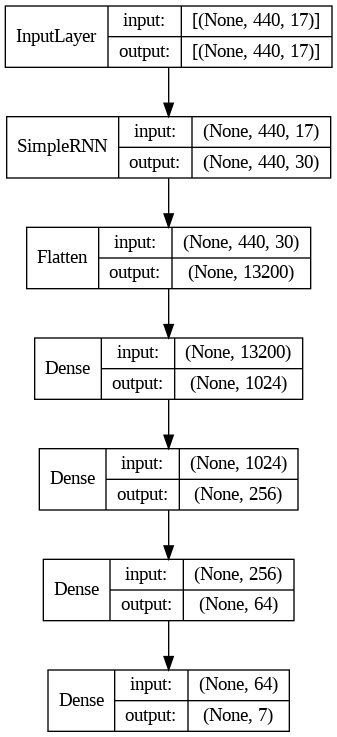

In [ ]:
#with tpu_strategy.scope():
rnn_lstm = tf.keras.Sequential([
    LSTM(30, input_shape=(440, 17), return_sequences = True),
    Flatten(),
    Dense(1024, activation='relu'),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(7)
])

rnn_lstm.compile(optimizer='adam', loss='mse', metrics=METRICS)
rnn_lstm.summary()
plot_model(rnn, to_file='figures/rnnlstm_1.png', show_shapes=True, show_layer_names=False)
#visualkeras.layered_view(rnn, legend=True, to_file='figures/rnnlstm_2.png', spacing = 15)

In [ ]:
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)
history = rnn_lstm.fit(X_train, y_train, validation_data=(X_validation, y_validation), epochs=100, verbose = 1, callbacks=[early_stopping])

Epoch 1/40
133/133 [==============================] - 7s 28ms/step - loss: 1.5324 - rmse: 1.2073 - mae: 0.8064 - r2score: -0.0461 - val_loss: 1.2350 - val_rmse: 1.1113 - val_mae: 0.7326 - val_r2score: 0.1627
Epoch 2/40
133/133 [==============================] - 4s 27ms/step - loss: 1.1708 - rmse: 1.0820 - mae: 0.7211 - r2score: 0.1654 - val_loss: 1.1219 - val_rmse: 1.0592 - val_mae: 0.7097 - val_r2score: 0.2144
Epoch 3/40
133/133 [==============================] - 3s 23ms/step - loss: 1.0595 - rmse: 1.0293 - mae: 0.6722 - r2score: 0.2581 - val_loss: 1.0382 - val_rmse: 1.0189 - val_mae: 0.6435 - val_r2score: 0.2978
Epoch 4/40
133/133 [==============================] - 3s 21ms/step - loss: 0.9686 - rmse: 0.9842 - mae: 0.6309 - r2score: 0.3207 - val_loss: 1.1084 - val_rmse: 1.0528 - val_mae: 0.6353 - val_r2score: 0.2314
Epoch 5/40
133/133 [==============================] - 3s 23ms/step - loss: 0.9255 - rmse: 0.9621 - mae: 0.6117 - r2score: 0.3559 - val_loss: 0.9738 - val_rmse: 0.9868 - va

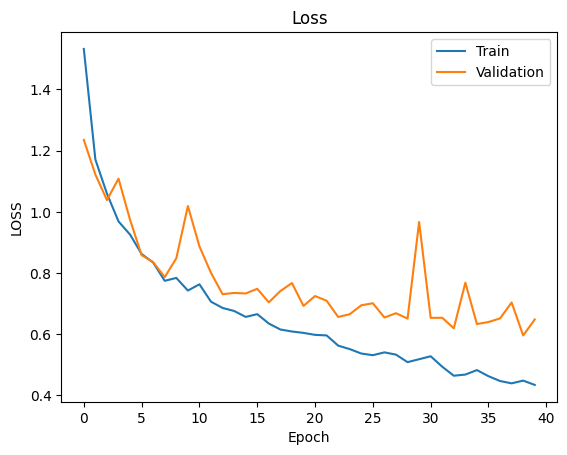

In [ ]:
model = 'rnn_lstm'
plot_metrics(history, 'loss', file = './figures/mse_small_{model}')
plot_metrics(history, 'rmse', file = './figures/rmse_small_{model}')
plot_metrics(history, 'mae', file = './figures/mae_small_{model}')
plot_metrics(history, 'r2score', file = './figures/r2score_small_{model}', lim_y_bottom = -1, lim_y_top = 2)
plot_metrics(history, 'e1_mse', file = './figures/e1_mse_small_{model}')
plot_metrics(history, 'e1_rmse', file = './figures/e1_rmse_small_{model}')
plot_metrics(history, 'e1_mae', file = './figures/e1_mae_small_{model}')
plot_metrics(history, 'e1_r2score', file = './figures/e1_r2score_small_{model}', lim_y_bottom = -1, lim_y_top = 2)
plot_metrics(history, 'e2_mse', file = './figures/e2_mse_small_{model}')
plot_metrics(history, 'e2_rmse', file = './figures/e2_rmse_small_{model}')
plot_metrics(history, 'e2_mae', file = './figures/e2_mae_small_{model}')
plot_metrics(history, 'e2_r2score', file = './figures/e2_r2score_small_{model}', lim_y_bottom = -1, lim_y_top = 2)

In [ ]:
model_evaluation(rnn_lstm, X_test, y_test,random_samples = 10)

45/45 [==============================] - 1s 19ms/step - loss: 0.6211 - rmse: 0.7881 - mae: 0.4548 - r2score: 0.5856
Test mse: 0.6210819482803345
Test rmse: 0.7880875468254089
Test mae: 0.45475098490715027
Test r2score: 0.5856307148933411
1/1 [==============================] - 0s 21ms/step


Random prediction examples
Parameters:	cx	cy	a	b	theta	e1	e2
------------
real:		 0.215	4.592	1.609	0.962	0.240	1.597	3.117
prediction:	 0.306	4.711	1.656	0.967	0.399	1.867	5.733
------------
real:		 0.012	3.989	1.308	0.054	0.082	3.562	6.931
prediction:	 0.039	3.931	0.765	0.145	0.137	3.630	4.698
------------
real:		 1.285	4.849	1.468	0.296	0.607	0.548	3.487
prediction:	 1.528	4.421	1.275	0.551	0.168	0.631	4.841
------------
real:		 -0.898	2.718	0.223	0.003	0.234	0.229	1.337
prediction:	 0.758	3.457	0.755	0.121	0.188	2.016	4.320
------------
real:		 2.017	3.743	0.896	0.689	0.170	4.390	5.150
prediction:	 2.490	4.388	1.325	0.730	0.258	4.730	4.859
------------
real:		 0.397	4.397	1.977	0.069	0.057	0.190